In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
1411,1998-12-02,1171.25,223.410004,-13.299184,-19.970626,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1412,1998-12-03,1150.14,219.720001,-14.349545,-19.801438,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1413,1998-12-04,1176.74,223.520004,-11.866565,-18.211425,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1414,1998-12-07,1187.70,226.330002,-12.322922,-18.915918,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1415,1998-12-08,1181.38,227.729996,-11.307808,-16.331104,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,5.426902,15.653446,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7195,2021-11-26,4594.62,1612.869995,4.573863,14.003887,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7196,2021-11-29,4655.27,1639.089966,8.977288,18.674877,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7197,2021-11-30,4567.00,1615.829956,6.305224,16.089746,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
133,2010,1,2010-01-14,1148.46,238.649994,8.787618,-2.687168,UNDERPERFORM,217.281,111.811,147.935,155.510,116.433,118.460,153.954,3
134,2010,2,2010-02-11,1078.47,230.320007,1.716544,-2.128923,UNDERPERFORM,217.353,111.683,150.515,158.916,115.187,118.827,153.889,3
135,2010,3,2010-03-11,1150.24,252.570007,2.657837,1.315742,UNDERPERFORM,217.403,111.397,151.482,159.927,115.393,118.613,154.230,3
136,2010,4,2010-04-08,1186.44,265.380005,13.110628,11.899140,UNDERPERFORM,217.290,111.206,153.708,162.861,114.808,118.712,154.265,3
137,2010,5,2010-05-13,1157.44,264.690002,-0.285160,-1.437344,UNDERPERFORM,217.199,110.989,152.352,161.356,114.465,119.592,153.796,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,-7.184331,-10.749254,UNDERPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,-6.940799,-11.868717,UNDERPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,-1.171440,0.458468,OUTPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,3.749053,11.528212,OUTPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [4]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [5]:
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
133,1,1148.46,238.649994,8.787618,-2.687168,217.281,111.811,147.935,155.510,116.433,118.460,153.954,3
134,2,1078.47,230.320007,1.716544,-2.128923,217.353,111.683,150.515,158.916,115.187,118.827,153.889,3
135,3,1150.24,252.570007,2.657837,1.315742,217.403,111.397,151.482,159.927,115.393,118.613,154.230,3
136,4,1186.44,265.380005,13.110628,11.899140,217.290,111.206,153.708,162.861,114.808,118.712,154.265,3
137,5,1157.44,264.690002,-0.285160,-1.437344,217.199,110.989,152.352,161.356,114.465,119.592,153.796,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.38,0.49,2,88
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
durables,float64,0,0,103.43,109.32,126.42,109.35,4.25,142,2
jewelry and watches,float64,0,0,147.94,168.67,187.66,168.30,7.56,142,2
jewelry,float64,0,0,155.51,174.24,186.34,173.55,6.49,143,1
watches,float64,0,0,113.42,124.52,153.74,129.45,11.34,143,1
sporting goods,float64,0,0,108.67,115.56,125.23,115.60,3.50,143,1
"pets, pet products and services",float64,0,0,153.80,168.39,188.69,169.15,8.51,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

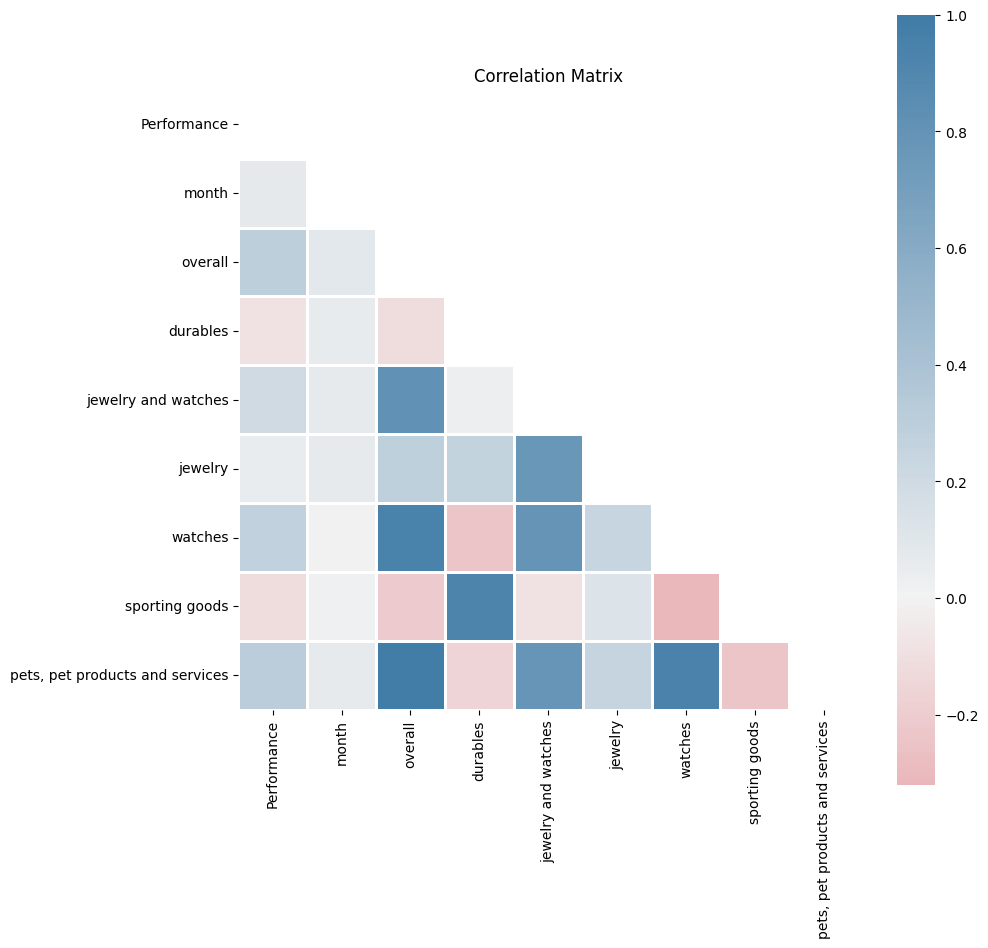

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,9,1675.412406,933.005160,-5.689946,-3.148330,242.612802,111.942001,163.190465,175.184330,139.144296,113.376090,160.473109,3
1,1,1591.545637,463.928624,4.791627,-2.001484,229.299531,111.754003,160.819118,169.528571,118.232644,119.198296,160.362651,3
2,5,1617.254022,284.025793,-11.027017,-11.585850,237.589856,112.751536,158.936064,164.247338,116.411155,119.520016,158.005215,3
3,2,2874.945732,778.718708,-4.312591,-7.739857,233.095559,105.661182,170.747040,176.720979,139.926494,112.146290,182.697416,3
4,8,1648.876255,318.292890,8.670270,4.894205,226.993464,110.572003,160.002485,171.004299,118.583507,117.483752,158.177463,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,2364.705921,642.101214,-3.746351,-6.709260,256.539677,112.252080,162.122279,166.940956,123.716530,120.032213,169.280363,3
9996,11,1994.166239,492.097405,-2.834714,-4.308226,233.531052,115.411915,172.227427,183.595549,117.968427,119.232973,160.437705,3
9997,2,3751.966350,1340.247821,7.192567,0.846961,263.110112,105.727144,174.553768,181.376810,143.755251,114.135947,185.104738,3
9998,4,1478.830644,364.610653,1.684277,3.047420,227.211122,110.595153,167.415368,175.565265,118.833068,118.354095,160.816860,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
samples.head()

,Performance,month,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
0,1,9,242.612802,111.942001,163.190465,175.184330,139.144296,113.376090,160.473109
1,0,1,229.299531,111.754003,160.819118,169.528571,118.232644,119.198296,160.362651
2,0,5,237.589856,112.751536,158.936064,164.247338,116.411155,119.520016,158.005215
3,0,2,233.095559,105.661182,170.747040,176.720979,139.926494,112.146290,182.697416
4,0,8,226.993464,110.572003,160.002485,171.004299,118.583507,117.483752,158.177463


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.56,0.50,2,5637
month,int64,0,0,1,6,12,6.38,3.42,12,911
overall,float64,0,0,210.86,240.91,296.97,243.34,16.10,10000,1
durables,float64,0,0,102.035,110.51,131.33,109.94,4.43,9999,2
jewelry and watches,float64,0,0,145.75,168.70,199.48,168.54,8.35,10000,1
jewelry,float64,0,0,156.56,174.70,190.24,174.082,6.20,10000,1
watches,float64,0,0,108.18,123.32,164.14,129.43,12.12,10000,1
sporting goods,float64,0,0,108.45,115.54,133.30,116.13,3.53,10000,1
"pets, pet products and services",float64,0,0,148.086,168.010,198.17,169.75,9.29,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

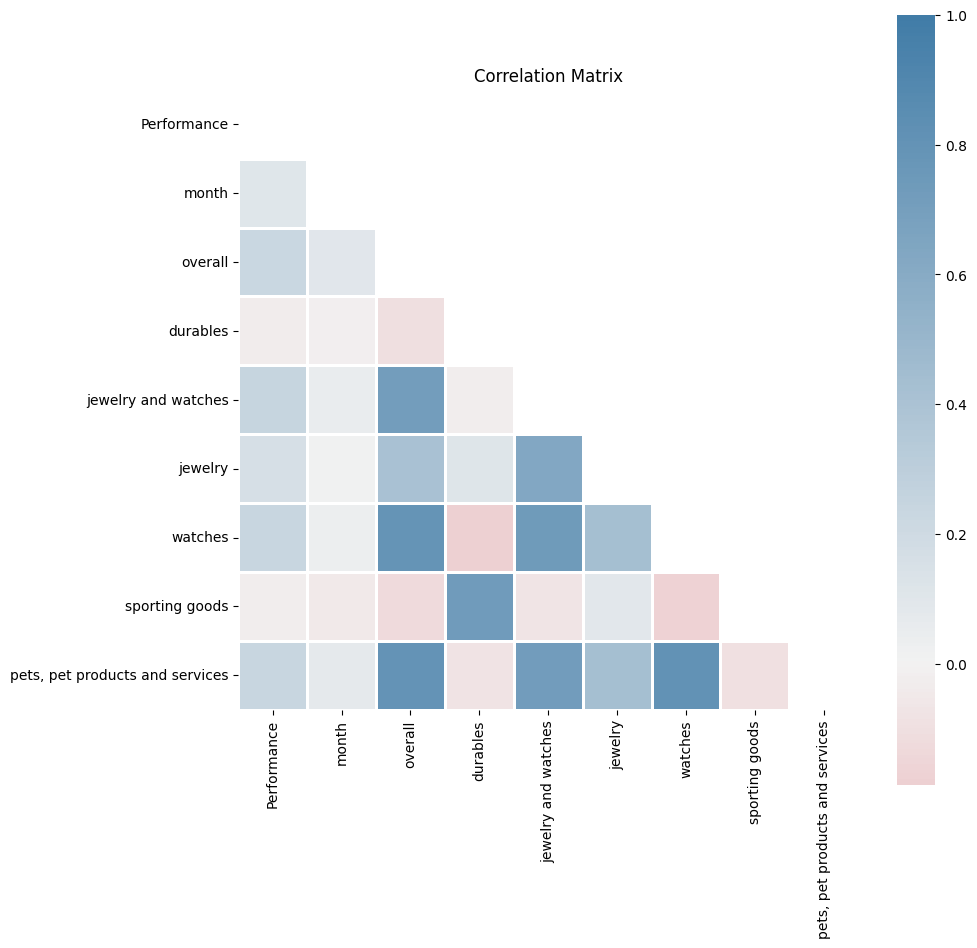

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 5637, 0: 4363})
Counter({1: 5637, 0: 5637})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  242.61280172,   111.94200068,   163.19046495, ...,
        15775.63618778, 22328.91781314, 18193.81358836],
       [  229.29953095,   111.75400282,   160.8191181 , ...,
        14093.1296367 , 18960.10011373, 19114.95468422],
       [  237.58985553,   112.75153615,   158.93606377, ...,
        13913.46314975, 18393.56950845, 18884.78584707],
       ...,
       [  230.2461233 ,   111.87415647,   166.53154883, ...,
        14018.48894106, 19638.35013091, 19586.55619004],
       [  255.99038831,   112.7713373 ,   171.84211978, ...,
        16708.49124727, 23740.29201669, 19605.80815502],
       [  222.96579727,   112.69938837,   152.00389353, ...,
        13532.57522109, 17886.04433208, 18489.58681502]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11274, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.646097,0.669558,0.595876,0.628405,0.63072,0.653785,0.579315,0.614302,0.587413,0.470588,0.581818,0.520325
1,DecisionTreeClassifier,0.611148,0.621282,0.588786,0.603176,0.599503,0.606188,0.602376,0.604276,0.531469,0.416667,0.545455,0.472441
2,RandomForestClassifier,0.686101,0.709968,0.649453,0.675737,0.679319,0.698568,0.647799,0.672226,0.608392,0.493506,0.690909,0.575758
3,AdaBoostClassifier,0.646973,0.658401,0.610784,0.633552,0.653423,0.678459,0.603075,0.63855,0.559441,0.435484,0.490909,0.461538
4,GradientBoostingClassifier,0.660723,0.677812,0.612739,0.643579,0.656616,0.68214,0.60587,0.641747,0.552448,0.428571,0.490909,0.457627
5,ExtraTreesClassifier,0.696127,0.727033,0.656722,0.685652,0.676836,0.699081,0.638015,0.667154,0.559441,0.444444,0.581818,0.503937
6,BaggingClassifier,0.657001,0.697519,0.569973,0.624951,0.642072,0.678209,0.561146,0.614149,0.622378,0.508772,0.527273,0.517857
7,SVC,0.627817,0.647457,0.561114,0.601161,0.628237,0.655818,0.563242,0.606015,0.622378,0.507692,0.6,0.55
8,GaussianNB,0.611674,0.668855,0.442436,0.532489,0.608372,0.66943,0.451433,0.539232,0.615385,0.5,0.4,0.444444


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.676126,0.691852,0.65269,0.671701


## Using all data (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,1998,12,1998-12-10,1165.02,225.119995,-12.539319,-16.890021,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600,3
1,1999,1,1999-01-14,1212.19,241.960007,-8.072711,-8.171082,UNDERPERFORM,164.700,126.200,141.300,146.200,124.700,121.200,102.500,3
2,1999,2,1999-02-11,1254.04,253.789993,-10.160045,-9.351005,OUTPERFORM,164.800,125.900,140.200,144.200,123.700,121.500,102.800,3
3,1999,3,1999-03-11,1297.68,270.940002,-1.853000,5.117363,OUTPERFORM,165.900,125.900,142.000,147.300,123.100,121.400,103.400,3
4,1999,4,1999-04-08,1343.98,282.480011,1.507530,10.950512,OUTPERFORM,166.000,125.700,142.500,148.000,123.100,121.000,103.600,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,-7.184331,-10.749254,UNDERPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,-6.940799,-11.868717,UNDERPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,-1.171440,0.458468,OUTPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,3.749053,11.528212,OUTPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [23]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,1,2195.110357,588.902008,-7.317496,-9.813260,199.648161,113.025642,163.265535,169.513724,121.158594,114.935701,150.290573,3
1,3,1269.418801,274.211951,-2.605295,-0.268610,204.758881,113.384378,138.059148,143.560607,119.521578,117.768702,160.982250,3
2,4,2781.520101,753.178447,-5.937646,1.378962,264.482207,102.484457,172.532613,180.675066,141.806336,112.004966,181.443666,3
3,7,1479.601232,1474.550421,-3.510540,-12.052512,239.624351,111.362000,171.432066,177.354457,141.290968,116.148614,175.847362,3
4,8,3862.011589,1080.839970,-11.121293,-11.641641,251.771277,109.188738,170.407758,173.939605,140.482584,116.823870,178.778465,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1140.789199,230.897307,-8.091890,-12.075777,168.062710,113.615560,135.697154,139.001739,116.471395,114.027082,110.885922,3
9996,5,2643.659259,632.584039,3.455772,-3.379947,241.807884,105.747826,170.541567,176.800842,128.246609,112.082823,166.374013,3
9997,5,1425.558777,261.152691,22.912810,20.863577,215.116710,112.829186,142.308222,164.837214,118.933393,118.524658,154.456314,3
9998,1,1467.942892,300.415670,-11.426466,-43.804866,195.774686,114.842436,137.433902,159.674805,119.104190,120.424359,160.713628,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.740435,0.682908,0.896042,0.774808,0.721372,0.673976,0.858724,0.755216,0.572464,0.523077,0.548387,0.535433
1,DecisionTreeClassifier,0.715831,0.696784,0.762797,0.727769,0.70686,0.69152,0.748023,0.718663,0.539855,0.481481,0.314516,0.380488
2,RandomForestClassifier,0.836148,0.814977,0.867942,0.83947,0.810818,0.802254,0.825514,0.813718,0.572464,0.571429,0.193548,0.289157
3,AdaBoostClassifier,0.665303,0.654016,0.699868,0.675932,0.660686,0.659364,0.666315,0.662821,0.586957,0.55102,0.435484,0.486486
4,GradientBoostingClassifier,0.686214,0.672973,0.722296,0.696516,0.683905,0.679139,0.698471,0.688669,0.557971,0.510417,0.395161,0.445455
5,ExtraTreesClassifier,0.873153,0.852036,0.902243,0.87567,0.841425,0.8361,0.849763,0.842876,0.557971,0.533333,0.129032,0.207792
6,BaggingClassifier,0.785356,0.786942,0.779947,0.782168,0.758047,0.767176,0.741697,0.754221,0.521739,0.413043,0.153226,0.223529
7,SVC,0.65653,0.636158,0.730079,0.679734,0.649604,0.635541,0.703216,0.667668,0.518116,0.466667,0.508065,0.486486
8,GaussianNB,0.552441,0.578576,0.386148,0.463123,0.559894,0.595021,0.377965,0.462282,0.496377,0.429907,0.370968,0.398268
